In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import sys
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals
from data.load_raw_data import load_pcd_plyfile_new_approach

plt.style.use('seaborn')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<hr>

# Semantic Segmentation Figures

In [40]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", False)

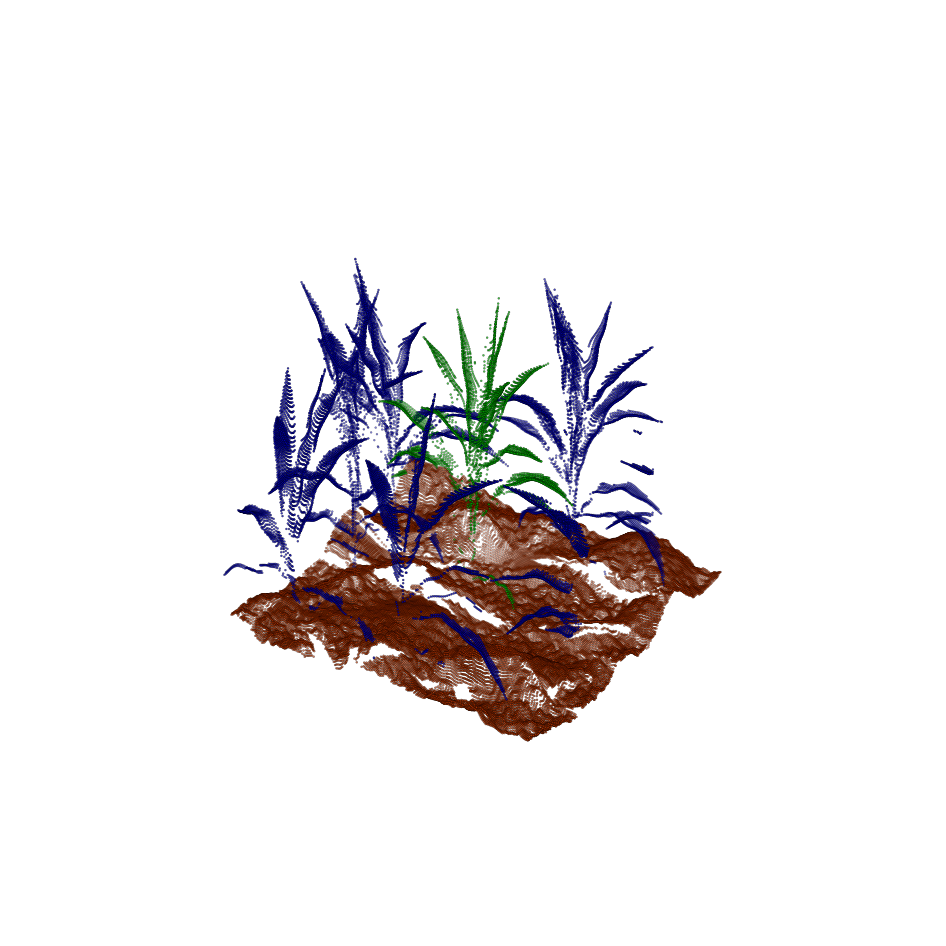

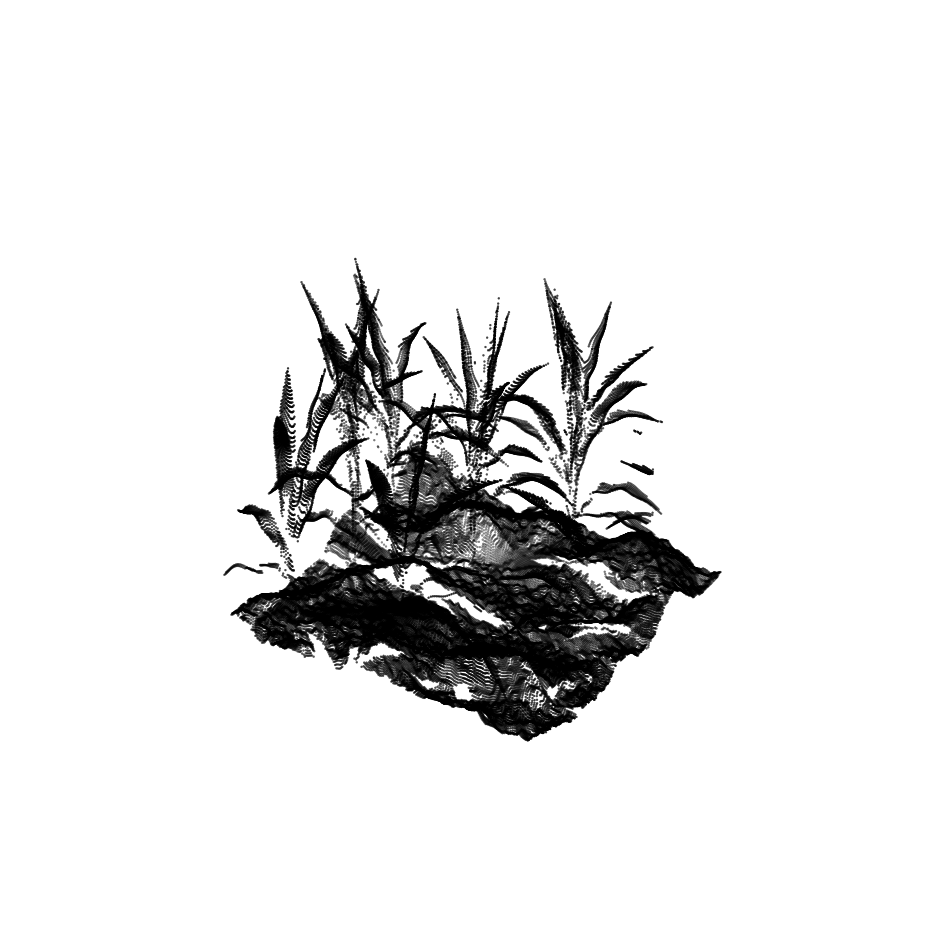

In [62]:
points, label = ply_file['points_full'], ply_file['labels_full'].squeeze()

d_colors = [[0.7, 0.2, 0], [0, 0.7, 0], [0, 0, 0.7]]
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c=colors)
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c='black')
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

<hr>

# Instance Segmentation Figures

In [2]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", True)

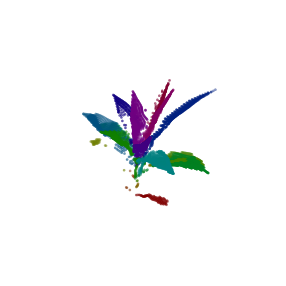

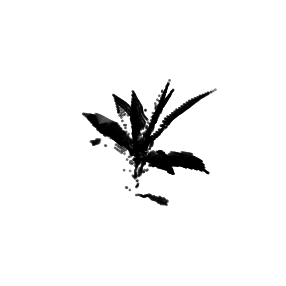

In [6]:
points, label = ply_file['points_full'], ply_file['labels_full'].squeeze()

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=5, c=colors)
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=5, c='black')
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

<hr>

# PCA to visualize the embedding space

In [1]:
from sklearn.decomposition import PCA 
import sys
sys.path.append("..")
from models.nn_models import SorghumPartNetInstance
from data.load_raw_data import load_pcd_plyfile_new_approach
import torch
import numpy as np
import matplotlib.pyplot as plt
from data.utils import distinct_colors
from train_and_inference.test import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/speedy/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_08/checkpoints/epoch=8-step=43199.ckpt")
sorghumpartnet = sorghumpartnet.cpu()
sorghumpartnet.DGCNN_feature_space.device = "cpu"

# sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/speedy/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_09/checkpoints/epoch=8-step=43199.ckpt")
# sorghumpartnet = sorghumpartnet.cpu()
# sorghumpartnet.DGCNN_feature_space.device = "cpu"

In [3]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", True)
points, label = ply_file['points'], ply_file['labels'].squeeze()

In [4]:
preds = sorghumpartnet(torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0).cpu())
preds = preds.squeeze().cpu().detach().numpy()

In [5]:
k = 200
tensor_points = torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0).cpu()
gt_clusters = torch.from_numpy(label).type(torch.FloatTensor).cpu()

num_points = gt_clusters.size(0)
num_dims = 1

distance = torch.cdist(tensor_points, tensor_points)
# idx = torch.topk(distance, k, -1)[1]
# idx = idx.squeeze()

# gt_clusters = gt_clusters.contiguous()

# knn_gt_labels = gt_clusters[idx]
# knn_gt_labels = knn_gt_labels.view(num_points, k)

# std_knn_gt_labels = torch.std(knn_gt_labels, 1)
# std_knn_gt_labels = (std_knn_gt_labels/std_knn_gt_labels.max())*0.8+0.2

distance = (distance.squeeze()<0.15)

count_knn_gt_labels = torch.zeros(num_points)
for i in range(num_points):
    tmp = torch.unique(gt_clusters[distance[i]], return_counts=True)[1]
    count_knn_gt_labels[i] = tmp.shape[0]

In [6]:
print(count_knn_gt_labels.min(), count_knn_gt_labels.max())
max_count = count_knn_gt_labels.max().int().item()

tensor(1.) tensor(13.)


In [30]:
# pca_3d = PCA(n_components = 3)
# pca_3d.fit(preds)
# data_pca_3d = pca_3d.transform(preds)

pca_2d = PCA(n_components = 2)
pca_2d.fit(preds)
data_pca_2d = pca_2d.transform(preds)

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :3] = d_colors[i]


pred_labels = get_final_clusters_SPN(preds,)
print(pred_labels.shape)

d_colors = distinct_colors(len(list(set(pred_labels))))
gt_colors = np.zeros((pred_labels.shape[0],3))
for i, l in enumerate(list(set(pred_labels))):
    gt_colors[label == l, :3] = d_colors[i]

    
fig = plt.figure(figsize=(24,24))

# ax1 = fig.add_subplot(3,2,1,projection='3d')
# ax1.scatter(data_pca_3d[:,0],data_pca_3d[:,1],data_pca_3d[:,2], s=5, c=colors)
# ax1.grid(True)
# ax1.set_facecolor("white")

# ax2 = fig.add_subplot(3,2,2,projection='3d')
# for i in range(count_knn_gt_labels.max().int().item()):
#     ind = count_knn_gt_labels==(i+1)
#     ax2.scatter(data_pca_3d[ind,0],data_pca_3d[ind,1],data_pca_3d[ind,2], s=(max_count-i+1)**2, c=colors[ind], marker='o', edgecolors='black', linewidth=0.4, alpha=1)

# ax2.grid(True)
# ax2.set_facecolor("white")

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(data_pca_2d[:,0],data_pca_2d[:,1], s=5, c=colors*1.4)
ax3.grid(True)
ax3.set_facecolor("white")

# ax4 = fig.add_subplot(2,2,2)
# for i in range(count_knn_gt_labels.max().int().item()):
#     ind = count_knn_gt_labels==(i+1)
#     ax4.scatter(data_pca_2d[ind,0],data_pca_2d[ind,1], s=15+(max_count-i+1)**2, c=colors[ind]*1.4, marker='o', edgecolors='black', linewidth=0.4, alpha=1)

# ax4.grid(True)
# ax4.set_facecolor("white")

# ax5 = fig.add_subplot(1,3,2,projection='3d')
# for i in range(max_count):
#     ind = count_knn_gt_labels==(i+1)
#     ax5.scatter(points[ind,0],points[ind,1],points[ind,2], s=(max_count-i+1)**1.5, c=colors[ind], marker='o', edgecolors='black', linewidth=0.4, alpha=0.75**(max_count-i+1))
# ax5.grid(False)
# ax5.axis("off")
# ax5.set_facecolor("white")

ax3 = fig.add_subplot(1,3,1, projection="3d")
ax3.scatter(points[:,0],points[:,1],points[:,2], s=5, c=gt_colors)
ax3.grid(True)
ax3.set_facecolor("white")

ax6 = fig.add_subplot(1,3,2,projection='3d')
ax6.scatter(points[:,0],points[:,1],points[:,2], s=5, c=colors)
ax6.grid(False)
ax6.axis("off")
ax6.set_facecolor("white")
plt.show()

(8000, 256)


TypeError: unhashable type: 'numpy.ndarray'

<hr>

# Printing Numbers for the Tables

In [19]:
import json

In [20]:
def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [44]:
full_result_real_08 = load_json("/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/EXP_08/real_data/full_results.json")
for key in full_result_real_08:
    # print(key, np.argmax(full_result_real_08[key]))
    print(key, np.argpartition(full_result_real_08[key], -2)[-2:])

pointwise_accuracies [4 3]
pointwise_precisions [1 0]
pointwise_recalls [3 4]
pointwise_f1s [4 3]
clusterbased_mean_coverages [3 0]
clusterbased_average_precisions [6 3]
clusterbased_average_recalls [3 0]


In [36]:
result_real_08 = load_json("/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/EXP_08/real_data/mean_results.json")
result_real_09 = load_json("/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/EXP_09/real_data/mean_results.json")
result_synt_08 = load_json("/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/EXP_08/test_set/mean_results.json")
# result_synt_09 = load_json("/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/EXP_09/test_set/mean_results.json")

print("real exp_08 ==> ", f"{result_real_08['clusterbased_mean_coverage']:4.2f}&{result_real_08['clusterbased_average_precision']:4.2f}&{result_real_08['clusterbased_average_recall']:4.2f}&{result_real_08['pointwise_accuracy']:4.2f}&{result_real_08['pointwise_precision']:4.2f}&{result_real_08['pointwise_recall']:4.2f}&{result_real_08['pointwise_f1']:4.2f}")
print("real exp_09 ==> ", f"{result_real_09['clusterbased_mean_coverage']:4.2f}&{result_real_09['clusterbased_average_precision']:4.2f}&{result_real_09['clusterbased_average_recall']:4.2f}&{result_real_09['pointwise_accuracy']:4.2f}&{result_real_09['pointwise_precision']:4.2f}&{result_real_09['pointwise_recall']:4.2f}&{result_real_09['pointwise_f1']:4.2f}")

print("synt exp_08 ==> ", f"{result_synt_08['clusterbased_mean_coverage']:4.2f}&{result_synt_08['clusterbased_average_precision']:4.2f}&{result_synt_08['clusterbased_average_recall']:4.2f}&{result_synt_08['pointwise_accuracy']:4.2f}&{result_synt_08['pointwise_precision']:4.2f}&{result_synt_08['pointwise_recall']:4.2f}&{result_synt_08['pointwise_f1']:4.2f}")
# print("synt exp_09 ==> ", f"{result_synt_09['clusterbased_mean_coverage']:4.2f}&{result_synt_09['clusterbased_average_precision']:4.2f}&{result_synt_09['clusterbased_average_recall']:4.2f}&{result_synt_09['pointwise_accuracy']:4.2f}&{result_synt_09['pointwise_precision']:4.2f}&{result_synt_09['pointwise_recall']:4.2f}&{result_synt_09['pointwise_f1']:4.2f}")


real exp_08 ==>  0.56&0.14&0.57&0.92&0.58&0.68&0.62
real exp_09 ==>  0.52&0.19&0.55&0.90&0.51&0.64&0.55
synt exp_08 ==>  0.75&0.12&0.79&0.97&0.84&0.87&0.85
